# IMPORTS AND READ CSV

In [58]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import yule_walker
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import normal_ad
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from scipy.signal import periodogram
from scipy import stats

In [4]:
df_time_series = pd.read_csv('datasets/historical_demand_sum.csv', index_col='time_index')
df_time_series.index = pd.to_datetime(df_time_series.index)
df_time_series.index = df_time_series.asfreq('MS').index
df_time_series.head()

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06


<AxesSubplot: xlabel='time_index'>

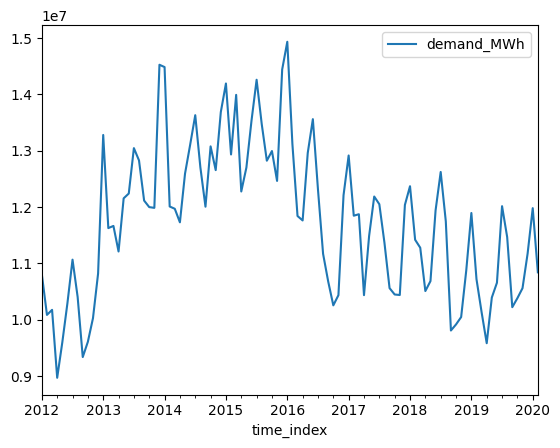

In [5]:
df_time_series.plot()

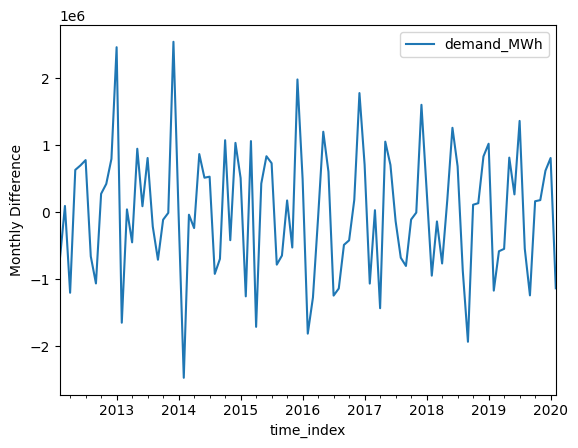

In [6]:
# Need to difference
df_time_series_diff_first = df_time_series.diff().dropna()
ax = df_time_series_diff_first.plot()
ax.set_ylabel("Monthly Difference")
plt.show()

In [7]:
utils.is_stationary(df_time_series_diff_first)

False

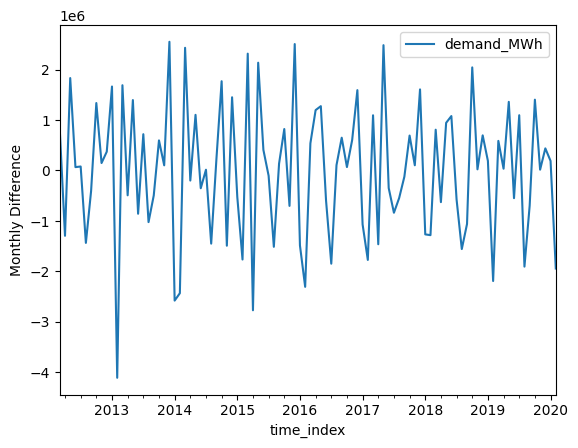

In [8]:
# Differenciate again
df_time_series_diff_second = df_time_series_diff_first.diff().dropna()
ax = df_time_series_diff_second.plot()
ax.set_ylabel("Monthly Difference")
plt.show()

In [9]:
utils.is_stationary(df_time_series_diff_second)

True

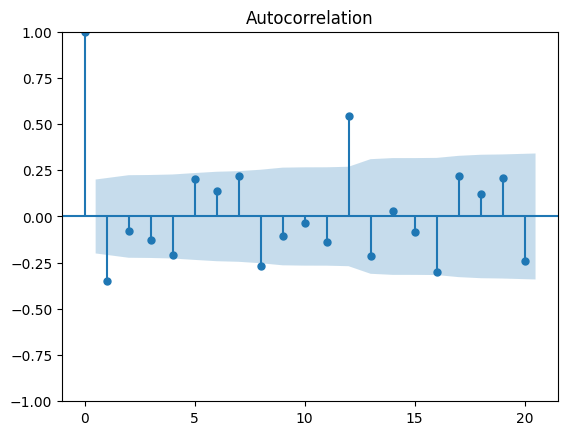

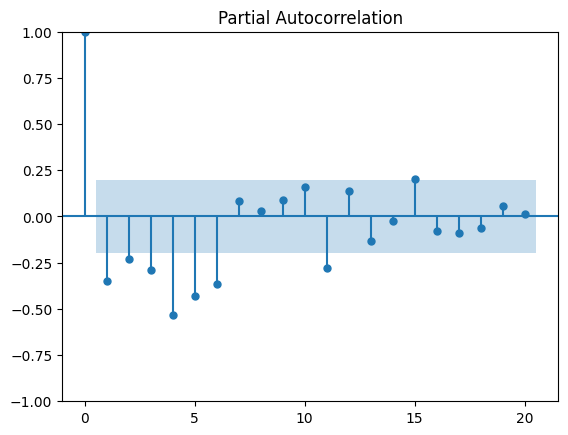

In [10]:
plot_acf(df_time_series_diff_second, lags=20)
plot_pacf(df_time_series_diff_second, lags=20, method="ywm")
plt.show()

r2_score: 0.6999744060057267
mean_absolute_error: 568504.1292410605
mean_absolute_percentage_error: 0.048162420374084115
mean_squared_error: 530313399871.8954
root_mean_squared_error: 728226.2010336454


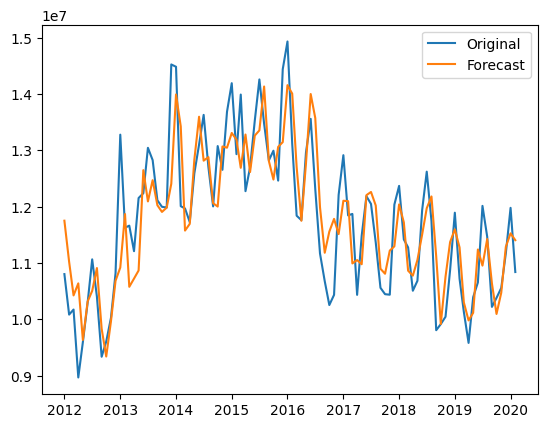

In [22]:
# Forecast the first ARMA(1,1) model
mod = ARIMA(df_time_series, order=(5,0,1))
res = mod.fit()
orig_data = df_time_series
pred = res.predict()
print(f'r2_score: {r2_score(orig_data, pred)}')
print(f'mean_absolute_error: {mean_absolute_error(orig_data, pred)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(orig_data, pred)}')
print(f'mean_squared_error: {mean_squared_error(orig_data, pred)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(orig_data, pred))}')
plt.plot(orig_data, label='Original')
plt.plot(pred, label='Forecast')
plt.legend()
plt.show()

# RESIDUALS

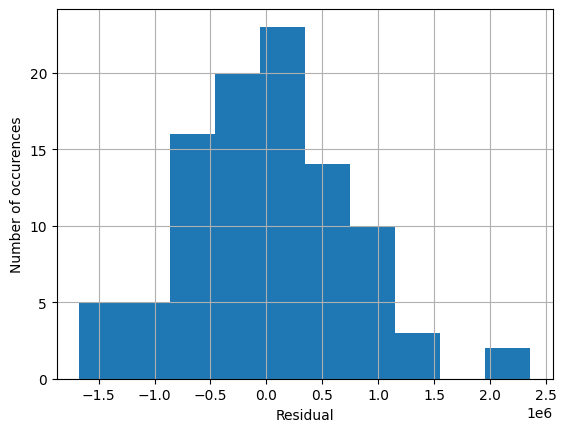

In [12]:
ax = pd.Series(res.resid).hist()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Residual')
plt.show()

In [13]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             demand_MWh   No. Observations:                   98
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -1461.492
Date:                Tue, 08 Nov 2022   AIC                           2938.984
Time:                        15:29:45   BIC                           2959.664
Sample:                    01-01-2012   HQIC                          2947.349
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.175e+07   1.41e-08   8.33e+14      0.000    1.18e+07    1.18e+07
ar.L1          0.7675      0.206      3.732      0.000       0.364       1.171
ar.L2         -0.1774      0.187     -0.947      0.343      -0.544       0.190
ar.L3         -0.0669      0.140     -0.478      0.632      -0.341       0.207
ar.L4         -0.0149      0.133     -0.112      0.911      -0.276       0.246
ar.L5          0.4325      0.136      3.188      0.001       0.167       0.698
ma.L1         -0.1368      0.241     -0.568      0.570      -0.608       0.335
sigma2      5.159e+11   6.21e-13   8.31e+23      0.000    5.16e+11    5.16e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.77
Prob(Q):                              0.98   Prob(JB):                         0.06
Heteroskedasticity (H):               0.40   Skew:                             0.50
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.59e+39. Standard errors may be unstable.
"""

# PMDARIMA

In [14]:
df_time_series[['demand_MWh']].tail(12)

,demand_MWh
time_index,
2019-03-01,1.013390e+07
2019-04-01,9.582935e+06
2019-05-01,1.039433e+07
2019-06-01,1.065671e+07
2019-07-01,1.201620e+07
2019-08-01,1.146801e+07
2019-09-01,1.022258e+07
2019-10-01,1.038260e+07
2019-11-01,1.055948e+07


In [15]:
df_time_series[['demand_MWh']]

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06
...,...
2019-10-01,1.038260e+07
2019-11-01,1.055948e+07
2019-12-01,1.117532e+07


In [16]:
train, test = train_test_split(df_time_series[['demand_MWh']], train_size=df_time_series[['demand_MWh']].size-14)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12, n_jobs=-1, stepwise=False)

# make your forecasts


In [17]:
test.shape[0]

14

In [18]:
forecasts_test_pmarima = model.predict(test.shape[0])  # predict N steps into the future

r2_score: 0.16625110540294086
mean_absolute_error: 532308.4018774417
mean_absolute_percentage_error: 0.04867598466883981
mean_squared_error: 434433841277.4847
root_mean_squared_error: 659115.9543490695


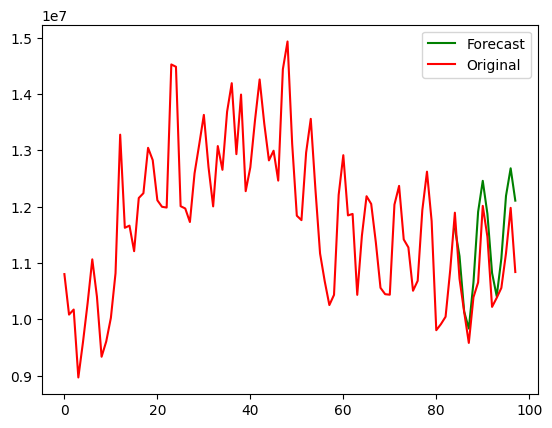

In [24]:
# Visualize the forecasts (blue=train, green=forecasts)
print(f'r2_score: {r2_score(test, forecasts_test_pmarima)}')
print(f'mean_absolute_error: {mean_absolute_error(test, forecasts_test_pmarima)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(test, forecasts_test_pmarima)}')
print(f'mean_squared_error: {mean_squared_error(test, forecasts_test_pmarima)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(test, forecasts_test_pmarima))}')
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[(df_time_series[['demand_MWh']].size-14):], forecasts_test_pmarima, c='green', label= 'Forecast')
plt.plot(x, df_time_series[['demand_MWh']], c='red', label= 'Original')
plt.legend()
plt.show()

r2_score: 0.16625110540294086


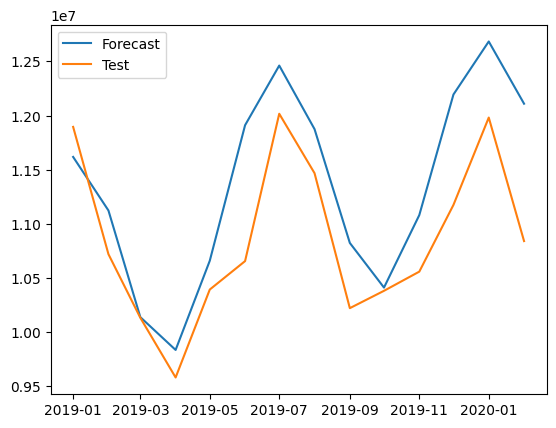

In [25]:

print(f'r2_score: {r2_score(test, forecasts_test_pmarima)}')
plt.plot(forecasts_test_pmarima, label='Forecast')
plt.plot(test, label='Test')
plt.legend()
plt.show()

In [26]:
model

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   84
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1252.801
Date:                Tue, 08 Nov 2022   AIC                           2519.601
Time:                        15:36:37   BIC                           2536.617
Sample:                    01-01-2012   HQIC                          2526.441
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.023e+06   6.71e-09   3.02e+14      0.000    2.02e+06    2.02e+06
ar.L1          1.8225      0.031     59.681      0.000       1.763       1.882
ar.L2         -1.8030      0.048    -37.473      0.000      -1.897      -1.709
ar.L3          0.8083      0.030     26.859      0.000       0.749       0.867
ma.L1         -1.1247      0.116     -9.697      0.000      -1.352      -0.897
ma.L2          0.9469      0.120      7.905      0.000       0.712       1.182
sigma2       5.74e+11   1.03e-13   5.56e+24      0.000    5.74e+11    5.74e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                 3.04
Prob(Q):                              0.22   Prob(JB):                         0.22
Heteroskedasticity (H):               0.54   Skew:                             0.41
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.09e+39. Standard errors may be unstable.
"""

In [28]:
pm.show_versions()


System:
    python: 3.8.10 (default, Mar 15 2022, 12:22:08)  [GCC 9.4.0]
executable: /home/tomas/codes/electric_energy_demand_argentina/env/bin/python
   machine: Linux-5.10.102.1-microsoft-standard-WSL2-x86_64-with-glibc2.29

Python dependencies:
        pip: 20.0.2
 setuptools: 44.0.0
    sklearn: 1.1.2
statsmodels: 0.13.2
      numpy: 1.23.3
      scipy: 1.9.2
     Cython: 0.29.32
     pandas: 1.5.0
     joblib: 1.2.0
   pmdarima: 2.0.1


# STATSMODEL SARIMA

In [29]:
train = df_time_series['demand_MWh'][:-12]
test = df_time_series['demand_MWh'][-12:]

In [30]:
mod = SARIMAX(train, order=(1,2,1), 
seasonal_order=(1,2,1,6))
res = mod.fit(disp=False)
forecasts_sarimax = res.forecast(steps=12)

-11.319069319127054


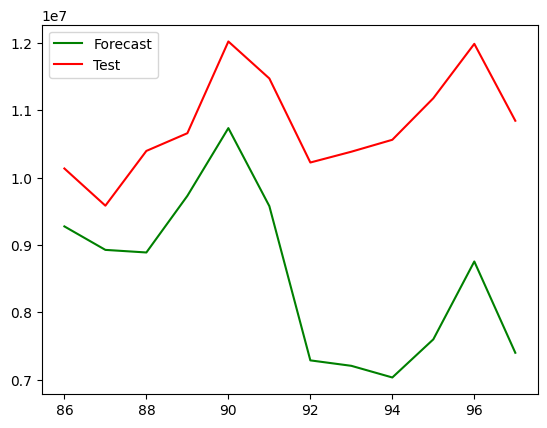

In [32]:
# Visualize the forecasts
print(r2_score(test, forecasts_sarimax))

x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()


# GRID SEARCH WITH SEASONALITY 6

In [23]:
scores = []
for p in range(2):
    for i in range(2):
        for q in range(2):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        try:
                            mod = SARIMAX(train, order=(p, i,q), seasonal_order=(P,D,Q,6))
                            res = mod.fit(disp=False)
                            score = [p,i,q,P,D,Q,r2_score(test, res.forecast(steps=12))]
                            print(score)
                            scores.append(score)
                            del mod
                            del res
                        except:
                            print('errored')
res = pd.DataFrame(scores)
res.columns = ['p', 'i', 'q', 'P', 'D', 'Q', 'score']
res.sort_values('score')

[0, 0, 0, 0, 0, 0, -227.46279693036848]
[0, 0, 0, 0, 0, 1, -156.70736523950904]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[0, 0, 0, 0, 1, 0, 0.7194222268340598]
[0, 0, 0, 0, 1, 1, 0.7235764703166702]
[0, 0, 0, 1, 0, 0, 0.6249191884604306]
[0, 0, 0, 1, 0, 1, 0.7819949041565684]
[0, 0, 0, 1, 1, 0, 0.725075501471498]
[0, 0, 0, 1, 1, 1, 0.5980279261312251]
[0, 0, 1, 0, 0, 0, -215.67163926355414]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[0, 0, 1, 0, 0, 1, -152.8424871722635]
[0, 0, 1, 0, 1, 0, 0.6626689410590202]
[0, 0, 1, 0, 1, 1, 0.7105781532959661]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[0, 0, 1, 1, 0, 0, -38.825712626643735]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[0, 0, 1, 1, 0, 1, -23.15362452208649]
[0, 0, 1, 1, 1, 0, 0.7307033567179828]
[0, 0, 1, 1, 1, 1, 0.6144561672141298]
[0, 1, 0, 0, 0, 0, -0.007984948244809997]
[0, 1, 0, 0, 0, 1, 0.02882338637009718]
[0, 1, 0, 0, 1, 0, -6.027489454574323]
[0, 1, 0, 0, 1, 1, -0.667385085043418]
[0, 1, 0, 1, 0, 0, 0.02825856076786748]
[0, 1, 0, 1, 0, 1, 0.6145947511776593]
[0, 1, 0, 1, 1, 0, -1.7522958840219198]
[0, 1, 0, 1, 1, 1, -0.7811715675541695]
[0, 1, 1, 0, 0, 0, -4.04818927381978e-05]
[0, 1, 1, 0, 0, 1, 0.08676238256738789]
[0, 1, 1, 0, 1, 0, -5.436860973510676]
[0, 1, 1, 0, 1, 1, -0.7104600034704118]
[0, 1, 1, 1, 0, 0, 0.13105600235882442]
[0, 1, 1, 1, 0, 1, 0.5963691495337133]
[0, 1, 1, 1, 1, 0, -1.7263442197063346]
[0, 1, 1, 1, 1, 1, -0.7836800452141]
[1, 0, 0, 0, 0, 0, -0.4402077985139494]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[1, 0, 0, 0, 0, 1, -0.8343599595688711]
[1, 0, 0, 0, 1, 0, 0.6397631728377728]
[1, 0, 0, 0, 1, 1, 0.7199334917065571]
[1, 0, 0, 1, 0, 0, -1.558170253606126]
[1, 0, 0, 1, 0, 1, 0.5125725674272762]
[1, 0, 0, 1, 1, 0, 0.7757679130814252]
[1, 0, 0, 1, 1, 1, 0.7477544871629401]
[1, 0, 1, 0, 0, 0, -0.44968605560255215]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[1, 0, 1, 0, 0, 1, 0.07021662354227354]
[1, 0, 1, 0, 1, 0, 0.5593983568126077]
[1, 0, 1, 0, 1, 1, 0.6290979515015402]
[1, 0, 1, 1, 0, 0, -0.5757410976953841]
[1, 0, 1, 1, 0, 1, 0.42458767273287135]
[1, 0, 1, 1, 1, 0, 0.6463558634281726]
[1, 0, 1, 1, 1, 1, 0.659026516615914]
[1, 1, 0, 0, 0, 0, -0.0010282521016855561]
[1, 1, 0, 0, 0, 1, 0.07651134097064216]
[1, 1, 0, 0, 1, 0, -5.411102633450167]
[1, 1, 0, 0, 1, 1, -0.6770533489895749]
[1, 1, 0, 1, 0, 0, 0.11443447173171184]
[1, 1, 0, 1, 0, 1, 0.5981146545325549]
[1, 1, 0, 1, 1, 0, -1.7351096915476618]
[1, 1, 0, 1, 1, 1, -0.7538963614350873]
[1, 1, 1, 0, 0, 0, 0.023974371526171767]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-i

[1, 1, 1, 0, 0, 1, 0.12442570426417998]
[1, 1, 1, 0, 1, 0, -5.3834449806671065]
[1, 1, 1, 0, 1, 1, -0.7330576640267019]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[1, 1, 1, 1, 0, 0, 0.1797936075487837]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[1, 1, 1, 1, 0, 1, 0.5625726672439237]
[1, 1, 1, 1, 1, 0, -1.647934303172247]
[1, 1, 1, 1, 1, 1, -0.818025053470764]


,p,i,q,P,D,Q,score
0,0,0,0,0,0,0,-227.462797
8,0,0,1,0,0,0,-215.671639
1,0,0,0,0,0,1,-156.707365
9,0,0,1,0,0,1,-152.842487
12,0,0,1,1,0,0,-38.825713
...,...,...,...,...,...,...,...
6,0,0,0,1,1,0,0.725076
14,0,0,1,1,1,0,0.730703
39,1,0,0,1,1,1,0.747754
38,1,0,0,1,1,0,0.775768


# GRID SEARCH WITH SEASONALITY 12

In [24]:
scores = []
for p in range(2):
    for i in range(2):
        for q in range(2):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        try:
                            mod = SARIMAX(train, order=(p,i,q), seasonal_order=(P,D,Q,12))
                            res = mod.fit(disp=False)
                            score = [p,i,q,P,D,Q,r2_score(test, res.forecast(steps=12))]
                            print(score)
                            scores.append(score)
                            del mod
                            del res
                        except:
                            print('errored')
res = pd.DataFrame(scores)
res.columns = ['p', 'i', 'q', 'P', 'D', 'Q', 'score']
res.sort_values('score')

[0, 0, 0, 0, 0, 0, -227.46279693036848]
[0, 0, 0, 0, 0, 1, -81.68331979182504]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[0, 0, 0, 0, 1, 0, 0.16643927358568267]
[0, 0, 0, 0, 1, 1, 0.05505809758836855]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


[0, 0, 0, 1, 0, 0, 0.2357226627260105]
[0, 0, 0, 1, 0, 1, 0.1985185348154911]
[0, 0, 0, 1, 1, 0, 0.09921537931489355]
[0, 0, 0, 1, 1, 1, 0.11026923736650407]
[0, 0, 1, 0, 0, 0, -215.67163926355414]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[0, 0, 1, 0, 0, 1, -98.85666559948888]
[0, 0, 1, 0, 1, 0, 0.28567124007469946]
[0, 0, 1, 0, 1, 1, 0.1670011925882663]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


[0, 0, 1, 1, 0, 0, -34.95901120808247]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[0, 0, 1, 1, 0, 1, -26.515181974664532]
[0, 0, 1, 1, 1, 0, 0.19045795855176773]
[0, 0, 1, 1, 1, 1, 0.20716279988485642]
[0, 1, 0, 0, 0, 0, -0.007984948244809997]
[0, 1, 0, 0, 0, 1, 0.23944497162593015]
[0, 1, 0, 0, 1, 0, -0.18926274608977]
[0, 1, 0, 0, 1, 1, -0.17958601147878617]
[0, 1, 0, 1, 0, 0, 0.3445580418624168]
[0, 1, 0, 1, 0, 1, 0.38857260080885003]
[0, 1, 0, 1, 1, 0, -0.18376546747663913]
[0, 1, 0, 1, 1, 1, -0.8783571312544662]
[0, 1, 1, 0, 0, 0, -4.04818927381978e-05]
[0, 1, 1, 0, 0, 1, 0.26859850825625275]
[0, 1, 1, 0, 1, 0, -0.20295465964834603]
[0, 1, 1, 0, 1, 1, -0.19365350534221948]
[0, 1, 1, 1, 0, 0, 0.3577167087277744]
[0, 1, 1, 1, 0, 1, 0.36612656627024964]
[0, 1, 1, 1, 1, 0, -0.19778047743602944]
[0, 1, 1, 1, 1, 1, -0.8024766295617229]
[1, 0, 0, 0, 0, 0, -0.4402077985139494]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[1, 0, 0, 0, 0, 1, -0.7124197941853534]
[1, 0, 0, 0, 1, 0, 0.3696428312806048]
[1, 0, 0, 0, 1, 1, 0.2257775424063101]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


[1, 0, 0, 1, 0, 0, -1.0641395318695261]
[1, 0, 0, 1, 0, 1, -0.010194721441151522]
[1, 0, 0, 1, 1, 0, 0.2265246293259373]
[1, 0, 0, 1, 1, 1, 0.24278354328720086]
[1, 0, 1, 0, 0, 0, -0.44968605560255215]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[1, 0, 1, 0, 0, 1, -0.4927953149954052]
[1, 0, 1, 0, 1, 0, 0.36864287936455287]
[1, 0, 1, 0, 1, 1, 0.19977957673579594]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


[1, 0, 1, 1, 0, 0, -0.10270936968310584]
[1, 0, 1, 1, 0, 1, 0.11041277508996739]
[1, 0, 1, 1, 1, 0, 0.20966376725402325]
[1, 0, 1, 1, 1, 1, 0.2270673828429146]
[1, 1, 0, 0, 0, 0, -0.0010282521016855561]
[1, 1, 0, 0, 0, 1, 0.2625359299963148]
[1, 1, 0, 0, 1, 0, -0.1982432307226556]
[1, 1, 0, 0, 1, 1, -0.18882742647341222]
[1, 1, 0, 1, 0, 0, 0.35448717786046136]
[1, 1, 0, 1, 0, 1, 0.365786190259767]
[1, 1, 0, 1, 1, 0, -0.19297815796141649]
[1, 1, 0, 1, 1, 1, -0.7769703877699266]
[1, 1, 1, 0, 0, 0, 0.023974371526171767]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-i

[1, 1, 1, 0, 0, 1, 0.30531510149908436]
[1, 1, 1, 0, 1, 0, 0.516255068057117]
[1, 1, 1, 0, 1, 1, 0.5167310545081799]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[1, 1, 1, 1, 0, 0, 0.4048634135564573]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[1, 1, 1, 1, 0, 1, 0.3913359907855244]
[1, 1, 1, 1, 1, 0, 0.516553646394097]
[1, 1, 1, 1, 1, 1, 0.32549570370620573]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,p,i,q,P,D,Q,score
0,0,0,0,0,0,0,-227.462797
8,0,0,1,0,0,0,-215.671639
9,0,0,1,0,0,1,-98.856666
1,0,0,0,0,0,1,-81.683320
12,0,0,1,1,0,0,-34.959011
...,...,...,...,...,...,...,...
61,1,1,1,1,0,1,0.391336
60,1,1,1,1,0,0,0.404863
58,1,1,1,0,1,0,0.516255
62,1,1,1,1,1,0,0.516554


In [48]:

mod = SARIMAX(train, order=(0,0,0), seasonal_order=(1,0,1,6))
res = mod.fit(disp=False)
forecasts_sarimax = res.forecast(steps=12)

0.7819949041565684
r2_score: 0.7819949041565684
mean_absolute_error: 281594.8362929619
mean_absolute_percentage_error: 0.026557639796868756
mean_squared_error: 111470749893.85674
root_mean_squared_error: 333872.35568980064


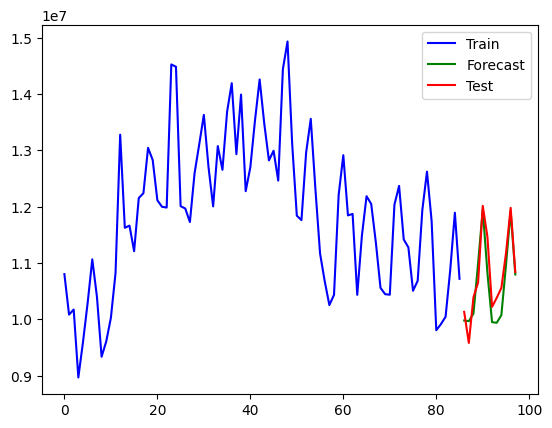

In [49]:
# Visualize the forecasts
print(r2_score(test, forecasts_sarimax))
print(f'r2_score: {r2_score(test, forecasts_sarimax)}')
print(f'mean_absolute_error: {mean_absolute_error(test, forecasts_sarimax)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(test, forecasts_sarimax)}')
print(f'mean_squared_error: {mean_squared_error(test, forecasts_sarimax)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(test, forecasts_sarimax))}')
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue', label='Train')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

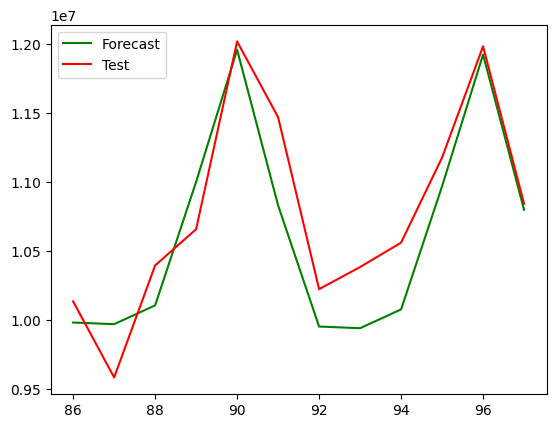

In [51]:
x = np.arange(df_time_series[['demand_MWh']].size)
# plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

# SARIMAX; BUSINESS DAYS AS EXOGENOUS VARIABLES

## WITHOUT GRID SEARCH

In [ ]:
df_time_series4['business_days'] = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in df_time_series4.index]

In [39]:
train_exog = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in train.index]
test_exog = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in test.index]

In [40]:
sarimax_model = SARIMAX(endog= train, exog= train_exog, order=(0,0,0), seasonal_order=(1,0,1,6))
res = sarimax_model.fit(disp=False)
forecasts_sarimax = res.forecast(steps=12, exog=test_exog)

0.7819949041565684
r2_score: 0.7819949041565684
mean_absolute_error: 281594.8362929619
mean_absolute_percentage_error: 0.026557639796868756
mean_squared_error: 111470749893.85674
root_mean_squared_error: 333872.35568980064


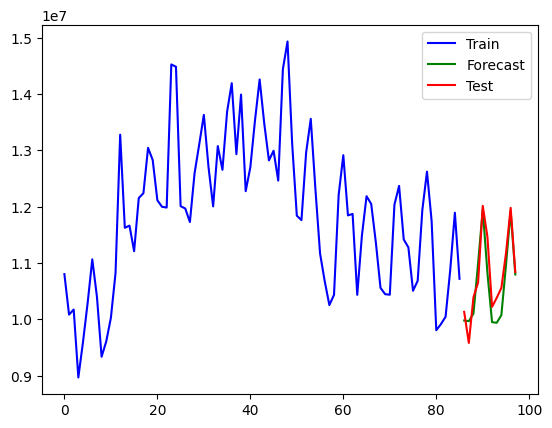

In [50]:
# Visualize the forecasts
print(r2_score(test, forecasts_sarimax))
print(f'r2_score: {r2_score(test, forecasts_sarimax)}')
print(f'mean_absolute_error: {mean_absolute_error(test, forecasts_sarimax)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(test, forecasts_sarimax)}')
print(f'mean_squared_error: {mean_squared_error(test, forecasts_sarimax)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(test, forecasts_sarimax))}')
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue', label='Train')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

## WITH GRIDSEARCH

In [44]:
scores = []
for p in range(2):
    for i in range(2):
        for q in range(2):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        try:
                            mod = SARIMAX(endog= train, exog= train_exog, order=(p,i,q), seasonal_order=(P,D,Q,6))
                            res = mod.fit(disp=False)
                            score = [p,i,q,P,D,Q,r2_score(test, res.forecast(steps=12, exog=test_exog))]
                            print(score)
                            scores.append(score)
                            del mod
                            del res
                        except:
                            print('errored')
res = pd.DataFrame(scores)
res.columns = ['p', 'i', 'q', 'P', 'D', 'Q', 'score']
res.sort_values('score')

[0, 0, 0, 0, 0, 0, -2.479140492503917]
[0, 0, 0, 0, 0, 1, -1.2610800983518242]
[0, 0, 0, 0, 1, 0, 0.8328773999519903]
[0, 0, 0, 0, 1, 1, 0.8398852889631782]
[0, 0, 0, 1, 0, 0, 0.39753190079647516]
[0, 0, 0, 1, 0, 1, 0.4581688706007896]
[0, 0, 0, 1, 1, 0, 0.8432817034912232]


/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0, 0, 0, 1, 1, 1, 0.6770173970711952]
[0, 0, 1, 0, 0, 0, -2.522971052264179]
[0, 0, 1, 0, 0, 1, -1.7067269631859547]
[0, 0, 1, 0, 1, 0, 0.8154912292680243]
[0, 0, 1, 0, 1, 1, 0.8621092068081789]
[0, 0, 1, 1, 0, 0, -0.3981225286118564]
[0, 0, 1, 1, 0, 1, -0.12018514061316288]
[0, 0, 1, 1, 1, 0, 0.8667550234263806]
[0, 0, 1, 1, 1, 1, 0.8193554709159503]
[0, 1, 0, 0, 0, 0, -0.12654544948205482]
[0, 1, 0, 0, 0, 1, 0.18320821320537506]
[0, 1, 0, 0, 1, 0, 0.023646824190393656]
[0, 1, 0, 0, 1, 1, 0.7812770380571643]
[0, 1, 0, 1, 0, 0, 0.5148624606332104]
[0, 1, 0, 1, 0, 1, 0.7591107549467799]
[0, 1, 0, 1, 1, 0, 0.15259166709641314]
[0, 1, 0, 1, 1, 1, 0.7159858337957483]
[0, 1, 1, 0, 0, 0, -0.04058694371202809]
[0, 1, 1, 0, 0, 1, 0.1875778444307421]
[0, 1, 1, 0, 1, 0, -0.6678952652992856]
[0, 1, 1, 0, 1, 1, 0.6706960110424937]
[0, 1, 1, 1, 0, 0, 0.5173393441609094]
[0, 1, 1, 1, 0, 1, 0.7670093882179236]
[0, 1, 1, 1, 1, 0, -0.05991625960980418]
[0, 1, 1, 1, 1, 1, 0.5948088763576234]
[1, 0, 0, 

,p,i,q,P,D,Q,score
8,0,0,1,0,0,0,-2.522971
0,0,0,0,0,0,0,-2.479140
40,1,0,1,0,0,0,-2.364412
32,1,0,0,0,0,0,-2.251010
9,0,0,1,0,0,1,-1.706727
...,...,...,...,...,...,...,...
3,0,0,0,0,1,1,0.839885
6,0,0,0,1,1,0,0.843282
11,0,0,1,0,1,1,0.862109
35,1,0,0,0,1,1,0.865327


In [53]:
sarimax_model = SARIMAX(endog= train, exog= train_exog, order=(0,0,1), seasonal_order=(1,1,0,6))
res = sarimax_model.fit(disp=False)
forecasts_sarimax = res.forecast(steps=12, exog=test_exog)

0.8667550234263806
r2_score: 0.8667550234263806
mean_absolute_error: 201281.18769217143
mean_absolute_percentage_error: 0.01913732584779668
mean_squared_error: 68131056298.41744
root_mean_squared_error: 261019.26422855735


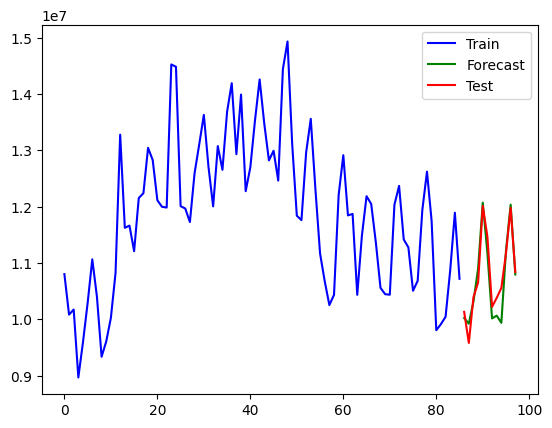

In [54]:
# Visualize the forecasts
print(r2_score(test, forecasts_sarimax))
print(f'r2_score: {r2_score(test, forecasts_sarimax)}')
print(f'mean_absolute_error: {mean_absolute_error(test, forecasts_sarimax)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(test, forecasts_sarimax)}')
print(f'mean_squared_error: {mean_squared_error(test, forecasts_sarimax)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(test, forecasts_sarimax))}')
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue', label='Train')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

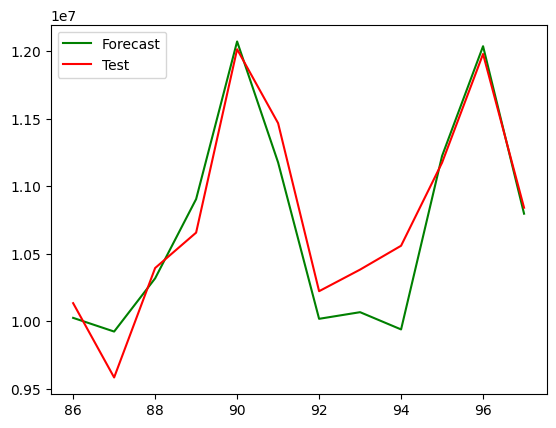

In [61]:
x = np.arange(df_time_series[['demand_MWh']].size)
# plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

# PREDICTION INTERVALS

In [56]:
residuals = test - forecasts_sarimax

/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


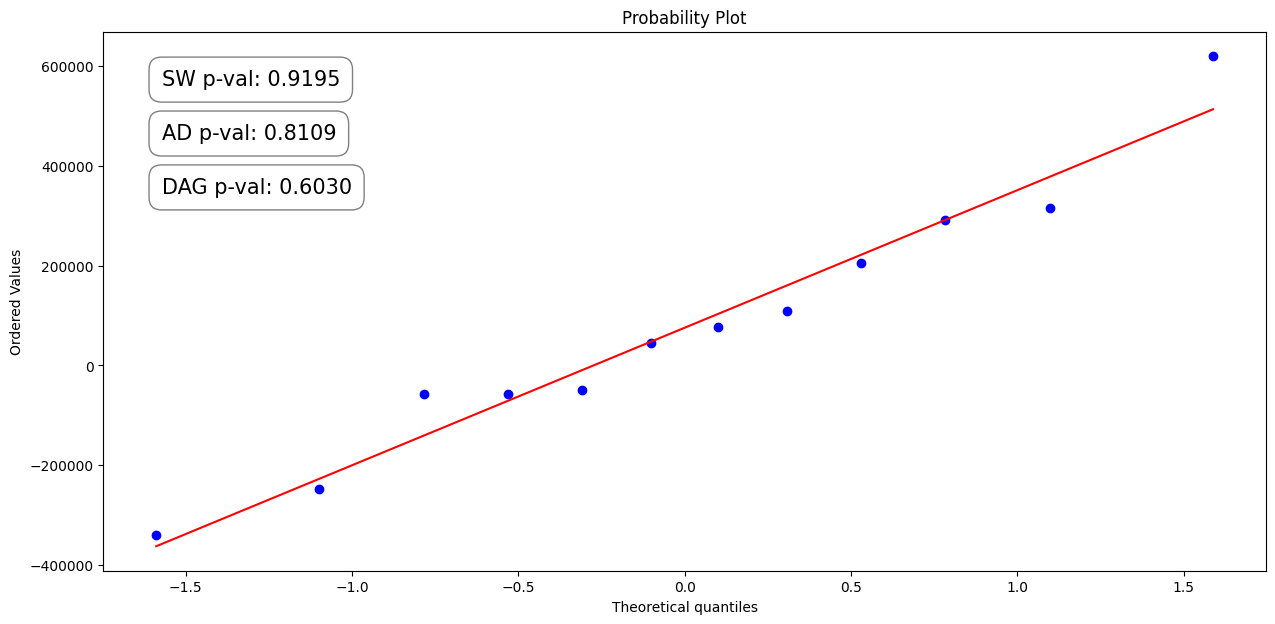

In [59]:
sw_result = stats.shapiro(residuals)
ad_result = normal_ad(np.array(residuals), axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

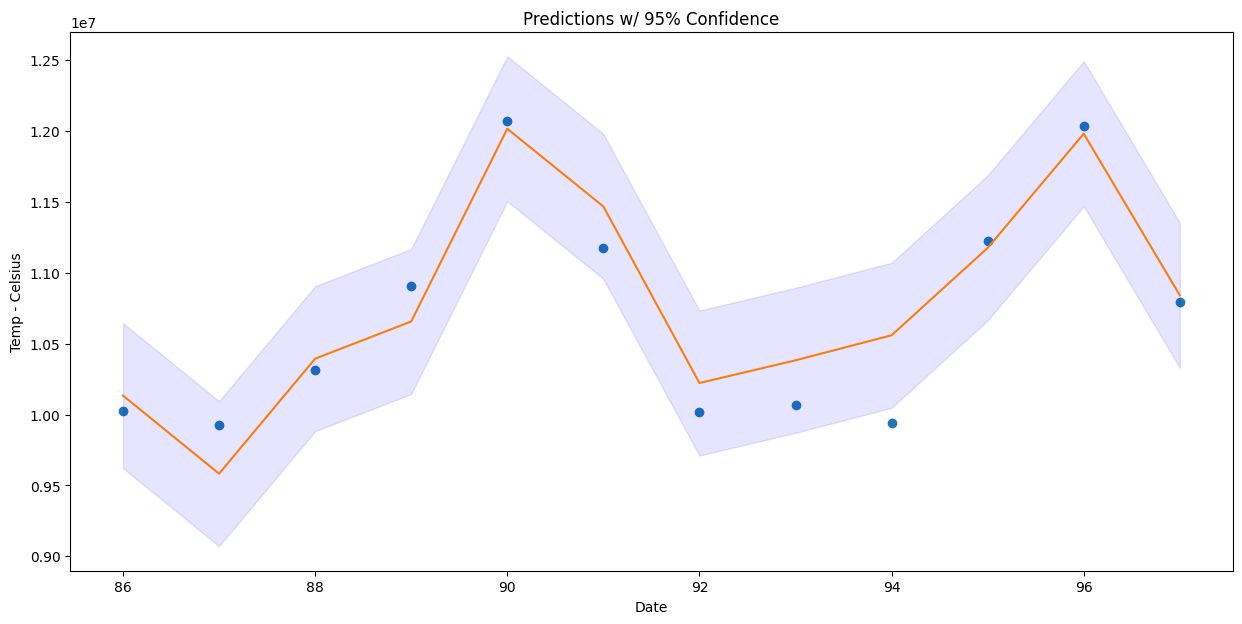

In [67]:
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x[(df_time_series[['demand_MWh']].size-12):], test, color='#fc7d0b', label='Valid')
ax.scatter(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax)
ax.fill_between(x[(df_time_series[['demand_MWh']].size-12):], (test-band_size), (test+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')
plt.show()